# <a id="table-of-contents"></a>Table of Contents

1. [Intraday Mean Reversion](#section1)
2. [Moving Average](#section2)
3. [OBV](#section3)


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression

In [2]:
# Define the path to the Downloads folder and the file
downloads_folder = os.path.expanduser("~/Desktop")
file_name = "aaHistoricalData_1726248252859.csv" 
file_path = os.path.join(downloads_folder, file_name)

# Read the CSV file into a DataFrame
data = pd.read_csv(file_path)

In [3]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Sort the DataFrame by date in ascending order
data = data.sort_values(by='Date', ascending=True)

print(data.head(3))

           Date  Close/Last     Volume    Open    High     Low
2515 2014-09-15     198.981   76350030  199.16  199.32  198.38
2514 2014-09-16     200.480  116039000  198.61  200.84  198.50
2513 2014-09-17     200.750  149647200  200.77  201.68  199.75


In [4]:
# Assuming 'data' is your existing DataFrame
data['Original_Index'] = data.index  # Add the Original_Index column to capture current index
print('''It will record the INDEX to make sure that future data manipulations don't force us to lose the order.''')

It will record the INDEX to make sure that future data manipulations don't force us to lose the order.


In [5]:
# Add new columns with the given calculations
data['High_minus_Open'] = (data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)
data['Open_minus_Low'] = (data['Open'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2)
data['day_change'] = (data['Close/Last'] - data['Close/Last'].shift(1)) / data['Close/Last'].shift(1)

data['opening_gaps'] = (data['Open'] - data['Close/Last'].shift(1)) / ((data['Open'] + data['Close/Last']) / 2)
data['net_Intraday_Movement_Around_Open'] = ((data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)) - ((data['Open'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2))

# Create moving average columns
data['MA_5'] = data['Open'].rolling(window=5).mean()
data['MA_14'] = data['Open'].rolling(window=14).mean()
data['MA_50'] = data['Open'].rolling(window=50).mean()
# "window=5" grabs at index 6 would grab 6,5,4,3,2


# Create lagged features comparing today's open to these moving averages
data['open_above_MA_5'] = (data['Open'] > data['MA_5']).astype(int)
data['open_above_MA_14'] = (data['Open'] > data['MA_14']).astype(int)
data['open_above_MA_50'] = (data['Open'] > data['MA_50']).astype(int)

data['MA_Crossover_Signal_5_14'] = (data['MA_5'] > data['MA_14']).astype(int)

# Create a binary indicator for whether yesterday's close was above or below the 5-day MA
data['yesterday_close_above_MA_5'] = (data['Close/Last'].shift(1) > data['MA_5']).astype(int)

column_names = data.columns
print(column_names)


Index(['Date', 'Close/Last', 'Volume', 'Open', 'High', 'Low', 'Original_Index',
       'High_minus_Open', 'Open_minus_Low', 'day_change', 'opening_gaps',
       'net_Intraday_Movement_Around_Open', 'MA_5', 'MA_14', 'MA_50',
       'open_above_MA_5', 'open_above_MA_14', 'open_above_MA_50',
       'MA_Crossover_Signal_5_14', 'yesterday_close_above_MA_5'],
      dtype='object')


# <a id="section1"></a>Intraday Mean Reversion
[Back to Table of Contents](#table-of-contents)


                                    OLS Regression Results                                   
Dep. Variable:     net_Intraday_Movement_Around_Open   R-squared:                       0.042
Model:                                           OLS   Adj. R-squared:                  0.041
Method:                                Least Squares   F-statistic:                     32.14
Date:                               Fri, 25 Oct 2024   Prob (F-statistic):           2.07e-08
Time:                                       12:27:12   Log-Likelihood:                 2217.1
No. Observations:                                727   AIC:                            -4430.
Df Residuals:                                    725   BIC:                            -4421.
Df Model:                                          1                                         
Covariance Type:                           nonrobust                                         
                   coef    std err          t      P>|t|    

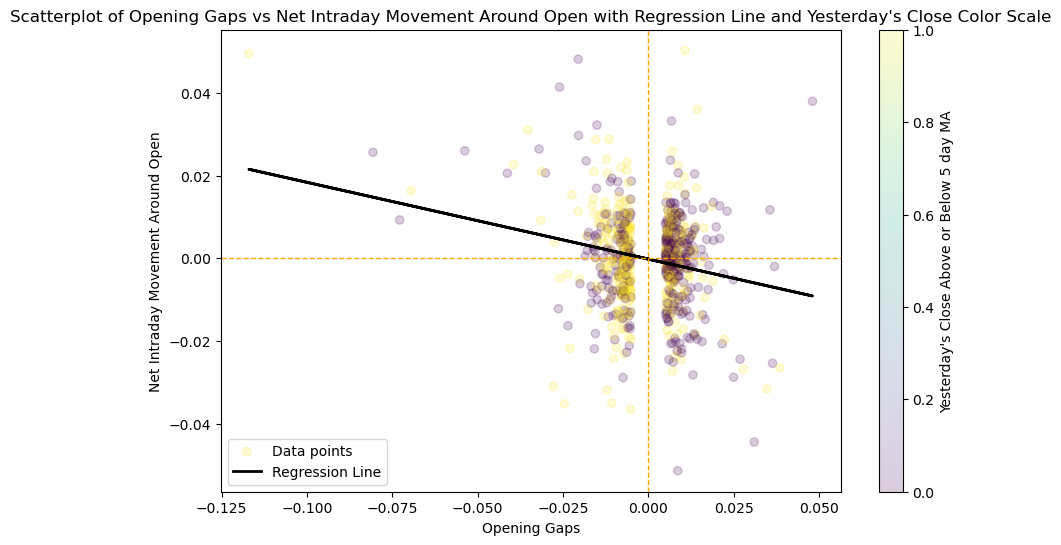

In [6]:
# Calculate the 5-day moving average
data['MA_5'] = data['Close/Last'].rolling(window=5).mean()

# Filter the DataFrame to exclude values with opening_gaps between -0.005 and 0.005 and greater than 0.05
filtered_data = data[(data['opening_gaps'] <= 0.05) & ((data['opening_gaps'] < -0.005) | (data['opening_gaps'] > 0.005))]

# Fit the regression model on the filtered data
X = filtered_data['opening_gaps']
y = filtered_data['net_Intraday_Movement_Around_Open']
X = sm.add_constant(X)  # Adds a constant term to the predictor
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(filtered_data['opening_gaps'], filtered_data['net_Intraday_Movement_Around_Open'], 
                      c=filtered_data['yesterday_close_above_MA_5'], cmap='viridis', alpha=0.2, label='Data points')

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Yesterday\'s Close Above or Below 5 day MA')

# Plot the regression line
plt.plot(filtered_data['opening_gaps'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Opening Gaps')
plt.ylabel('Net Intraday Movement Around Open')
plt.title('Scatterplot of Opening Gaps vs Net Intraday Movement Around Open with Regression Line and Yesterday\'s Close Color Scale')

# Add dashed lines at x=0 and y=0
plt.axvline(x=0, color='orange', linestyle='--', linewidth=1)
plt.axhline(y=0, color='orange', linestyle='--', linewidth=1)

# Add legend
plt.legend()

# Show and save the plot
plt.show()


In [7]:
print('''

It's not unusual, and it does carry significance. When combining the data sets for positive and negative gaps, the combined model provides a more comprehensive picture of the 
behavior, capturing broader patterns. Here's why you're seeing those higher values:

Higher R-squared: This indicates that the combined model explains a larger proportion of the variance in net intraday movement. Essentially, it captures more of the overall
behavior by integrating both up and down gaps.

Higher Coefficient: The larger coefficient suggests that opening gaps have a more pronounced impact on net intraday movement when viewed collectively.

Higher Absolute T-value: The stronger t-value underlines the statistical significance of the relationship, implying that your findings are highly unlikely to be due to random 
chance.

In essence, combining the datasets amplifies the signal of the relationship, making it more robust and detectable. This comprehensive approach gives you a clearer understanding of
the market dynamics at play.

Exactly! What you're saying lines up with our logic. Typically, larger down gaps tend to occur when prices are above the 5-day MA, 
signaling some potential pullback or profit-taking

''')



It's not unusual, and it does carry significance. When combining the data sets for positive and negative gaps, the combined model provides a more comprehensive picture of the 
behavior, capturing broader patterns. Here's why you're seeing those higher values:

Higher R-squared: This indicates that the combined model explains a larger proportion of the variance in net intraday movement. Essentially, it captures more of the overall
behavior by integrating both up and down gaps.

Higher Coefficient: The larger coefficient suggests that opening gaps have a more pronounced impact on net intraday movement when viewed collectively.

Higher Absolute T-value: The stronger t-value underlines the statistical significance of the relationship, implying that your findings are highly unlikely to be due to random 
chance.

In essence, combining the datasets amplifies the signal of the relationship, making it more robust and detectable. This comprehensive approach gives you a clearer understanding of

                            OLS Regression Results                            
Dep. Variable:         Open_minus_Low   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     73.28
Date:                Fri, 25 Oct 2024   Prob (F-statistic):           2.61e-16
Time:                        12:27:12   Log-Likelihood:                 1362.4
No. Observations:                 393   AIC:                            -2721.
Df Residuals:                     391   BIC:                            -2713.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0023      0.001      3.099   

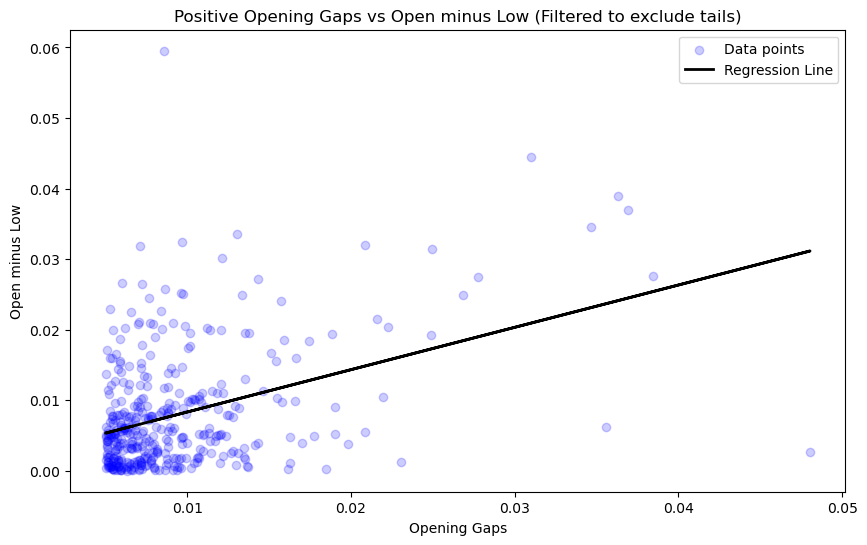


shows mean reversion for the up gaps




In [8]:
# Filter the DataFrame to include only positive opening gaps greater than 0.005 and less than 0.05
filtered_data = data[(data['opening_gaps'] > 0.005) & (data['opening_gaps'] <= 0.05)]

# Fit the regression model with opening_gaps driving Open_minus_Low
X = filtered_data['opening_gaps']
y = filtered_data['Open_minus_Low']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['opening_gaps'], filtered_data['Open_minus_Low'], color='blue', alpha=0.2, label='Data points')

# Plot the regression line
plt.plot(filtered_data['opening_gaps'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Opening Gaps')
plt.ylabel('Open minus Low')
plt.title('Positive Opening Gaps vs Open minus Low (Filtered to exclude tails)')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

print('''
shows mean reversion for the up gaps

''')

                            OLS Regression Results                            
Dep. Variable:        High_minus_Open   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     115.4
Date:                Fri, 25 Oct 2024   Prob (F-statistic):           2.94e-23
Time:                        12:27:12   Log-Likelihood:                 1178.5
No. Observations:                 329   AIC:                            -2353.
Df Residuals:                     327   BIC:                            -2345.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0014      0.001      1.908   

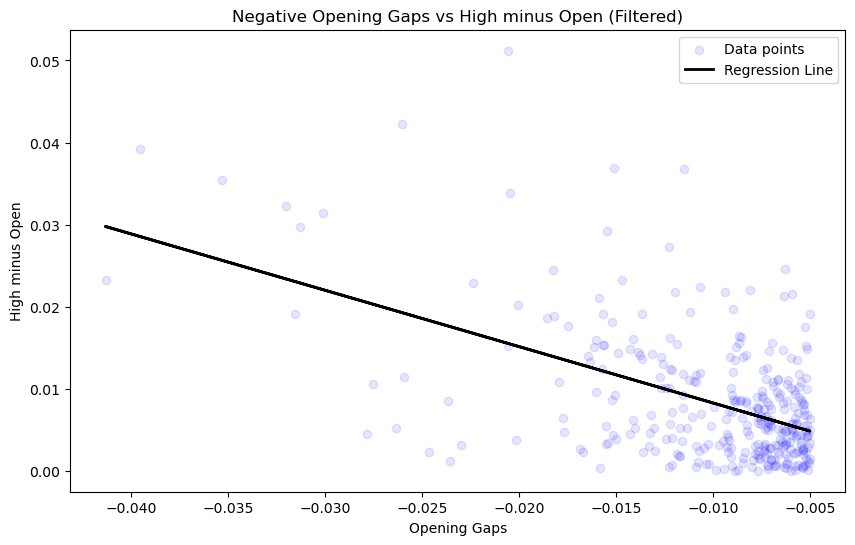



You're right: this data shows an even stronger mean reversion for down gaps. The significant negative coefficient (-0.4782) indicates that as the negative opening gap widens,
the high-minus-open value tends to decrease significantly. This supports the notion of a robust mean reversion effect for down gaps. The R-squared value of 0.265 is notable, 
indicating that 26.5% of the variability in High_minus_Open is explained by the negative opening gaps.




In [9]:
# Filter the DataFrame to include only negative opening gaps between -0.05 and -0.005
filtered_data = data[(data['opening_gaps'] < -0.005) & (data['opening_gaps'] >= -0.05)]

# Fit the regression model with opening_gaps driving High_minus_Open
X = filtered_data['opening_gaps']
y = filtered_data['High_minus_Open']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['opening_gaps'], filtered_data['High_minus_Open'], color='blue', alpha=0.1, label='Data points')

# Plot the regression line
plt.plot(filtered_data['opening_gaps'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Opening Gaps')
plt.ylabel('High minus Open')
plt.title('Negative Opening Gaps vs High minus Open (Filtered)')

# Add legend
plt.legend()

# Show and save the plot
plt.show()


print('''

You're right: this data shows an even stronger mean reversion for down gaps. The significant negative coefficient (-0.4782) indicates that as the negative opening gap widens,
the high-minus-open value tends to decrease significantly. This supports the notion of a robust mean reversion effect for down gaps. The R-squared value of 0.265 is notable, 
indicating that 26.5% of the variability in High_minus_Open is explained by the negative opening gaps.

''')

## <a id="section2"></a> Moving Averages: Today's Price Change

                            OLS Regression Results                            
Dep. Variable:             day_change   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     67.49
Date:                Fri, 25 Oct 2024   Prob (F-statistic):           3.35e-16
Time:                        12:27:12   Log-Likelihood:                 7769.0
No. Observations:                2515   AIC:                        -1.553e+04
Df Residuals:                    2513   BIC:                        -1.552e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0017      0.000     

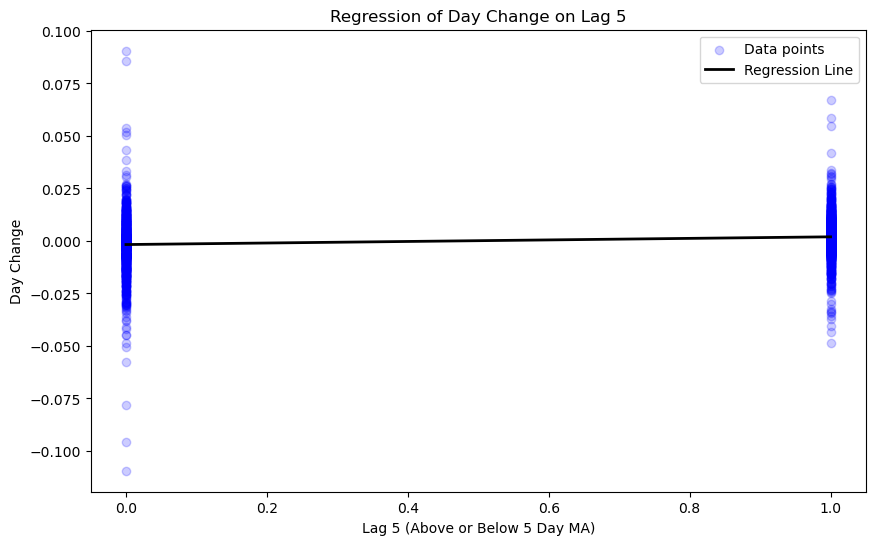

In [10]:
# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['open_above_MA_5', 'day_change'])

# Independent variable (lag_5) and dependent variable (day_change)
X = clean_data[['open_above_MA_5']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(clean_data['open_above_MA_5'], clean_data['day_change'], color='blue', alpha=0.2, label='Data points')
plt.plot(clean_data['open_above_MA_5'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Lag 5 (Above or Below 5 Day MA)')
plt.ylabel('Day Change')
plt.title('Regression of Day Change on Lag 5')

# Add legend
plt.legend()

# Show and save the plot
plt.show()


                            OLS Regression Results                            
Dep. Variable:             day_change   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     29.88
Date:                Fri, 25 Oct 2024   Prob (F-statistic):           5.06e-08
Time:                        12:27:12   Log-Likelihood:                 7750.5
No. Observations:                2515   AIC:                        -1.550e+04
Df Residuals:                    2513   BIC:                        -1.549e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0012      0.000  

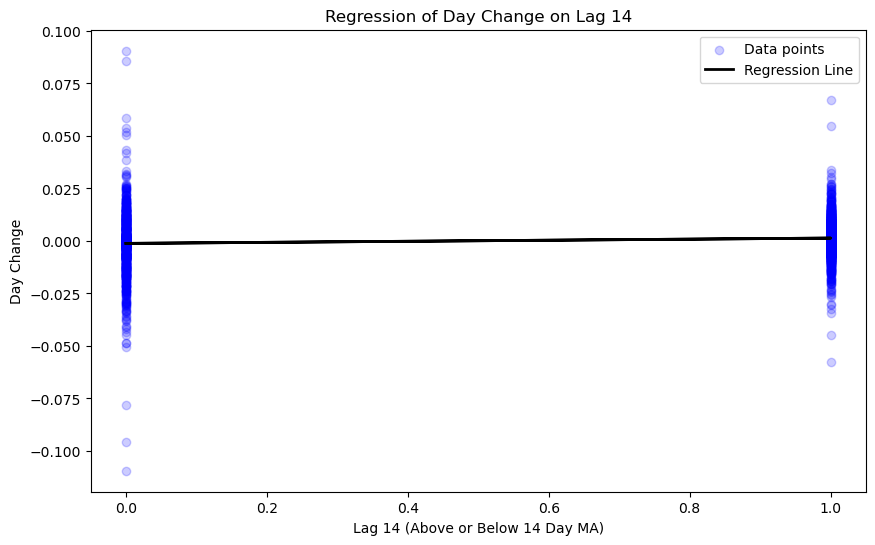

In [11]:
# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['open_above_MA_14', 'day_change'])

# Independent variable (lag_5) and dependent variable (day_change)
X = clean_data[['open_above_MA_14']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(clean_data['open_above_MA_14'], clean_data['day_change'], color='blue', alpha=0.2, label='Data points')
plt.plot(clean_data['open_above_MA_14'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Lag 14 (Above or Below 14 Day MA)')
plt.ylabel('Day Change')
plt.title('Regression of Day Change on Lag 14')

# Add legend
plt.legend()

# Show and save the plot
plt.show()


                            OLS Regression Results                            
Dep. Variable:             day_change   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.614
Date:                Fri, 25 Oct 2024   Prob (F-statistic):             0.0574
Time:                        12:27:12   Log-Likelihood:                 7737.5
No. Observations:                2515   AIC:                        -1.547e+04
Df Residuals:                    2513   BIC:                        -1.546e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0002      0.000  

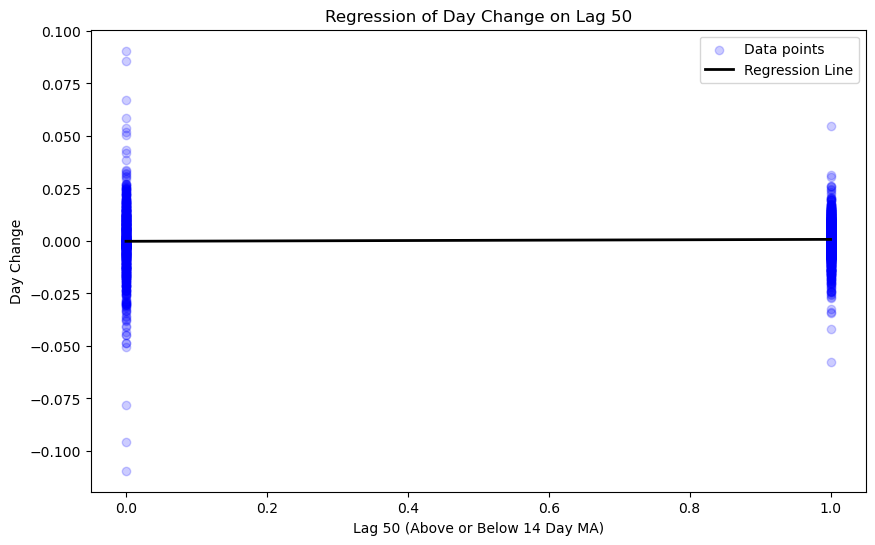

In [12]:
# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['open_above_MA_50', 'day_change'])

# Independent variable (lag_5) and dependent variable (day_change)
X = clean_data[['open_above_MA_50']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(clean_data['open_above_MA_50'], clean_data['day_change'], color='blue', alpha=0.2, label='Data points')
plt.plot(clean_data['open_above_MA_50'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Lag 50 (Above or Below 14 Day MA)')
plt.ylabel('Day Change')
plt.title('Regression of Day Change on Lag 50')

# Add legend
plt.legend()

# Show and save the plot
plt.show()


In [13]:
print('''
all 3 regressions indicate MA are immaterial as predictor or day price change
''')


all 3 regressions indicate MA are immaterial as predictor or day price change



                            OLS Regression Results                            
Dep. Variable:             day_change   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     23.09
Date:                Fri, 25 Oct 2024   Prob (F-statistic):           9.60e-15
Time:                        12:27:13   Log-Likelihood:                 7769.9
No. Observations:                2515   AIC:                        -1.553e+04
Df Residuals:                    2511   BIC:                        -1.551e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0017      0.000  

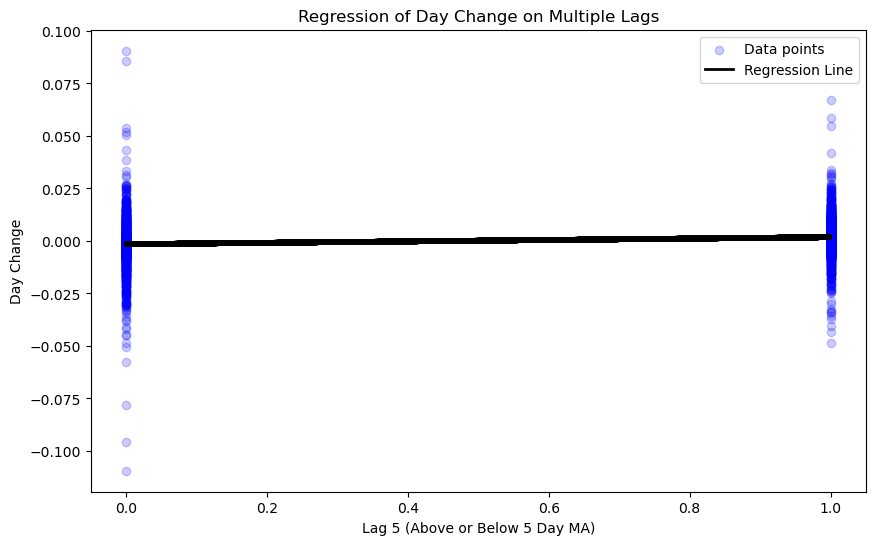

In [14]:
# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['open_above_MA_5', 'open_above_MA_14', 'open_above_MA_50', 'day_change'])

# Independent variables and dependent variable
X = clean_data[['open_above_MA_5', 'open_above_MA_14', 'open_above_MA_50']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the multiple linear regression model
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot for one of the variables (lag_5 as an example)
plt.figure(figsize=(10, 6))
plt.scatter(clean_data['open_above_MA_5'], clean_data['day_change'], color='blue', alpha=0.2, label='Data points')

# Plot the regression line for one variable (lag_5)
plt.plot(clean_data['open_above_MA_5'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Lag 5 (Above or Below 5 Day MA)')
plt.ylabel('Day Change')
plt.title('Regression of Day Change on Multiple Lags')

# Add legend
plt.legend()

# Show and save the plot
plt.savefig('regression_day_change_on_multiple_lags.png', dpi=300)
plt.show()


In [15]:
print('''

Exactly. Multicollinearity is a valid concern here. If the 5-day MA significantly predicts price movement, the 14-day and 50-day MAs are likely to be highly correlated with it,
as they incorporate overlapping data. You're correct. Multicollinearity doesn't affect the coefficients themselves but does inflate the standard errors, impacting the t-scores 
and p-values.

Given your coefficients are already very low and the R-squared is modest, it suggests that these variables (lag_5, lag_14, and open_above_MA_50) aren't strong predictors of day change. 
The significant p-values for lag_5 and lag_14 indicate they have some relationship, but their practical impact is minimal. The 50-day lag is particularly irrelevant with a high 
p-value and near-zero coefficient.

''')



Exactly. Multicollinearity is a valid concern here. If the 5-day MA significantly predicts price movement, the 14-day and 50-day MAs are likely to be highly correlated with it,
as they incorporate overlapping data. You're correct. Multicollinearity doesn't affect the coefficients themselves but does inflate the standard errors, impacting the t-scores 
and p-values.

Given your coefficients are already very low and the R-squared is modest, it suggests that these variables (lag_5, lag_14, and open_above_MA_50) aren't strong predictors of day change. 
The significant p-values for lag_5 and lag_14 indicate they have some relationship, but their practical impact is minimal. The 50-day lag is particularly irrelevant with a high 
p-value and near-zero coefficient.




In [16]:

# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['open_above_MA_5', 'open_above_MA_14', 'open_above_MA_50', 'day_change'])

# Independent variables
X = clean_data[['open_above_MA_5', 'open_above_MA_14', 'open_above_MA_50']]

# Add a constant term to the predictor
X = sm.add_constant(X)

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


            feature       VIF
0             const  4.024110
1   open_above_MA_5  1.472361
2  open_above_MA_14  1.820981
3  open_above_MA_50  1.334948


In [17]:
print('''

Exactly. The low VIF values indicate that these moving averages are not strongly related to each other in predicting daily changes. This reinforces the idea that the data lacks 
a significant trend within the 5, 14, and 50-day windows. It suggests a level of randomness, with no clear pattern or momentum over these periods. So, the moving averages are not 
trending indicators in this context. What's your next data adventure?

''')



Exactly. The low VIF values indicate that these moving averages are not strongly related to each other in predicting daily changes. This reinforces the idea that the data lacks 
a significant trend within the 5, 14, and 50-day windows. It suggests a level of randomness, with no clear pattern or momentum over these periods. So, the moving averages are not 
trending indicators in this context. What's your next data adventure?




                            OLS Regression Results                            
Dep. Variable:             day_change   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  0.004385
Date:                Fri, 25 Oct 2024   Prob (F-statistic):              0.947
Time:                        12:27:13   Log-Likelihood:                 7578.4
No. Observations:                2467   AIC:                        -1.515e+04
Df Residuals:                    2465   BIC:                        -1.514e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0005      0.001     

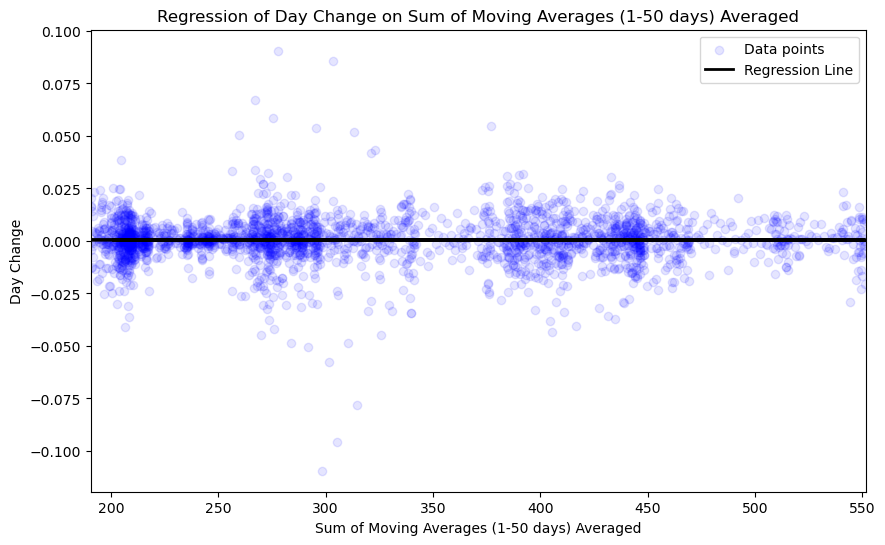

In [18]:
# Initialize the column to store the sum of moving averages
data['Sum_MA_1_50'] = 0

# Calculate and sum the moving averages from 1 to 50 days
for i in range(1, 51):
    # Calculate the moving average for each window size 'i'
    ma = data['Close/Last'].rolling(window=i).mean()
    # Add the calculated moving average to 'Sum_MA_1_50'
    data['Sum_MA_1_50'] += ma

# Divide by 50 to get the average
data['Sum_MA_1_50_Avg'] = data['Sum_MA_1_50'] / 50

# Ensure 'day_change' is defined
data['day_change'] = (data['Close/Last'] - data['Close/Last'].shift(1)) / data['Close/Last'].shift(1)

# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['Sum_MA_1_50_Avg', 'day_change'])

# Independent variable and dependent variable
X = clean_data[['Sum_MA_1_50_Avg']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(clean_data['Sum_MA_1_50_Avg'], clean_data['day_change'], color='blue', alpha=0.1, label='Data points')

# Plot the regression line
plt.plot(clean_data['Sum_MA_1_50_Avg'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Sum of Moving Averages (1-50 days) Averaged')
plt.ylabel('Day Change')
plt.title('Regression of Day Change on Sum of Moving Averages (1-50 days) Averaged')

# Set the x-axis limit to fit the range of 'Sum_MA_1_50_Avg'
plt.xlim(clean_data['Sum_MA_1_50_Avg'].min(), clean_data['Sum_MA_1_50_Avg'].max())

# Add legend
plt.legend()

# Show and save the plot
plt.show()


In [19]:
print('''

Exactly. The OLS results show that the average of the MAs isn't predictive for day-to-day price changes. The small coefficient, 
high p-value, and low R-squared all suggest the sum of moving averages isn't a useful predictor.

This finding aligns with your earlier insights about the lack of significance in individual moving averages. So, it seems like moving
averages, at least in these configurations, don't offer predictive power for daily changes.

''')



Exactly. The OLS results show that the average of the MAs isn't predictive for day-to-day price changes. The small coefficient, 
high p-value, and low R-squared all suggest the sum of moving averages isn't a useful predictor.

This finding aligns with your earlier insights about the lack of significance in individual moving averages. So, it seems like moving
averages, at least in these configurations, don't offer predictive power for daily changes.




# <a id="section3"></a> OBV


In [20]:
data['OBV'] = 0

# Initialize the first value of OBV
data.loc[0, 'OBV'] = data.loc[0, 'Volume']

# Calculate OBV
for i in range(1, len(data)):
    if data.loc[i, 'Close/Last'] > data.loc[i-1, 'Close/Last']:
        data.loc[i, 'OBV'] = data.loc[i-1, 'OBV'] + data.loc[i, 'Volume']
    elif data.loc[i, 'Close/Last'] < data.loc[i-1, 'Close/Last']:
        data.loc[i, 'OBV'] = data.loc[i-1, 'OBV'] - data.loc[i, 'Volume']
    else:
        data.loc[i, 'OBV'] = data.loc[i-1, 'OBV']

          Date  Close/Last         OBV
175 2024-01-02      472.65 -1720700740
174 2024-01-03      468.79 -1843708540
173 2024-01-04      467.28 -1947294440
172 2024-01-05      467.92 -1863062270
171 2024-01-08      474.60 -1776943360


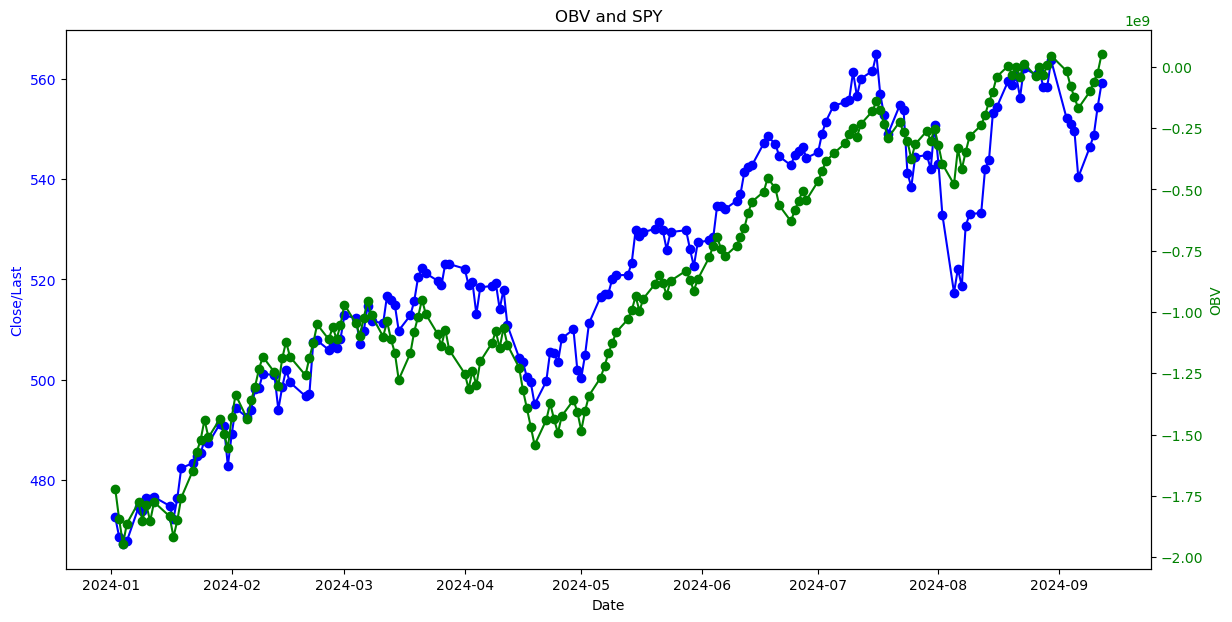


You're capturing the differences between OBV and SPY percentage changes over rolling windows, updating based on the maximum observed difference, and assessing 
retracements to set the OBV_SPY_metric.



In [21]:
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Filter data to include only dates in the year 2024
data_2024 = data[data['Date'].dt.year == 2024]

# Display the first few rows to check the new DataFrame
print(data_2024[['Date', 'Close/Last', 'OBV']].head())

# Create dual-axis plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Close/Last on the first y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Close/Last', color='blue')
ax1.plot(data_2024['Date'], data_2024['Close/Last'], color='blue', marker='o')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for OBV
ax2 = ax1.twinx()
ax2.set_ylabel('OBV', color='green')
ax2.plot(data_2024['Date'], data_2024['OBV'], color='green', marker='o')
ax2.tick_params(axis='y', labelcolor='green')

# Add a title
plt.title('OBV and SPY')

# Show the plot
plt.show()


print('''
You're capturing the differences between OBV and SPY percentage changes over rolling windows, updating based on the maximum observed difference, and assessing 
retracements to set the OBV_SPY_metric.
''')

In [22]:
def calculate_obv_spy_metric_backward(data, initial_window_size=5, threshold=25):
    data['OBV_SPY_MAX_DIFF'] = np.nan  # Initialize the new independent variable column
    data['OBV_SPY_window_length'] = np.nan  # Initialize column for window length
    data['OBV_SPY_MAX_DIFF_INDEX'] = np.nan  # Initialize column to store index of max diff
    data['Max_Diff_Original_Index'] = np.nan  # Initialize new column to store index of max diff
    data['divergence_sign'] = np.nan  # Initialize column for divergence sign

    for i in range(initial_window_size, len(data)):  # Start from initial_window_size to ensure at least 5 loops
        max_diff = 0
        max_diff_index = data['Original_Index'].iloc[i]  # Initialize max_diff_index to current index
        j = 0
        obv_late = data['OBV'].iloc[i]  # Fixed to the current index in the outer loop
        spy_late = data['Close/Last'].iloc[i]  # Fixed to the current index in the outer loop

        while i - j >= 0:
            obv_early = data['OBV'].iloc[i-j]
            spy_early = data['Close/Last'].iloc[i-j]

            obv_pct_change = (obv_late - obv_early) / obv_early * 100
            spy_pct_change = (spy_late - spy_early) / spy_early * 100  

            obv_spy_pct_diff = obv_pct_change - spy_pct_change
            abs_current_diff = abs(obv_spy_pct_diff)

            # Determine divergence type
            if obv_spy_pct_diff >= 0:
                data.at[i, 'divergence_sign'] = "Positive_Divergence"
            elif obv_spy_pct_diff < 0: 
                data.at[i, 'divergence_sign'] = "Negative_Divergence"

            if abs_current_diff > max_diff:
                max_diff = abs_current_diff
                max_diff_index = data['Original_Index'].iloc[i-j]  # Update max_diff_index to Original_Index

            # Break condition
            if j >= initial_window_size and abs_current_diff <= 0.75 * max_diff:
                break

            j += 1  # Increment j by 1 to expand window backward

        data.at[i, 'OBV_SPY_MAX_DIFF'] = max_diff
        data.at[i, 'OBV_SPY_window_length'] = j
        data.at[i, 'Max_Diff_Original_Index'] = max_diff_index  # Store the index of the max diff

    return data

# Apply the function to the DataFrame
data = calculate_obv_spy_metric_backward(data)

# Drop rows with NaN values in OBV_SPY_MAX_DIFF
data.dropna(subset=['OBV_SPY_MAX_DIFF'], inplace=True)

# Print results to verify
print(data[['Date', 'Original_Index', 'OBV', 'OBV_SPY_MAX_DIFF', 'OBV_SPY_window_length', 'Max_Diff_Original_Index', 'divergence_sign']].head(35))


           Date  Original_Index          OBV  OBV_SPY_MAX_DIFF  \
2515 2014-09-15            2515 -18703866840        323.025182   
2514 2014-09-16            2514 -18627516810         88.756537   
2513 2014-09-17            2513 -18511477810        907.458388   
2512 2014-09-18            2512 -18361830610        504.591016   
2511 2014-09-19            2511 -18456246210       2381.263717   
2510 2014-09-22            2510 -18577620110       1783.471563   
2509 2014-09-23            2509 -18702961210       7716.059994   
2508 2014-09-24            2508 -18591857610       1581.996062   
2507 2014-09-25            2507 -18698955610       4766.491532   
2506 2014-09-26            2506 -18548964810        846.843253   
2505 2014-09-29            2505 -18652468710       4427.302167   
2504 2014-09-30            2504 -18747530290        157.466898   
2503 2014-10-01            2503 -18877417590       4842.791299   
2502 2014-10-02            2502 -18699815190       1963.451432   
2501 2014-

In [23]:
# Filter the DataFrame for 'OBV_SPY_window_length' values over 12
filtered_data = data[data['OBV_SPY_window_length'] > 9]

# Sort the filtered DataFrame by the 'Max_Diff_Original_Index' column
filtered_data = filtered_data.sort_values(by='Max_Diff_Original_Index')

# Create the "index_percent_change" column for 2% test
filtered_data['max_index_percent_change'] = filtered_data['Max_Diff_Original_Index'].pct_change() * 100

# Drop NaNs resulting from pct_change calculation
filtered_data = filtered_data.dropna(subset=['max_index_percent_change']).reset_index(drop=True)

# Initialize the "New_OBV_Trend" column with 0
filtered_data['New_OBV_Trend'] = 0

# Iterate through the DataFrame to set "New_OBV_Trend" based on both conditions
for i in range(1, len(filtered_data)):
    if abs(filtered_data['max_index_percent_change'].iloc[i]) >= .02 and abs(filtered_data['Max_Diff_Original_Index'].iloc[i] - filtered_data['Max_Diff_Original_Index'].iloc[i-1]) >= 5:
        filtered_data.at[i, 'New_OBV_Trend'] = 1

# Display the filtered data
print(filtered_data[['Max_Diff_Original_Index', 'Date', 'OBV_SPY_MAX_DIFF', 'OBV_SPY_window_length', 
                     'OBV', 'max_index_percent_change', 'divergence_sign','New_OBV_Trend']].head(3))

   Max_Diff_Original_Index       Date  OBV_SPY_MAX_DIFF  \
0                     27.0 2014-10-10         85.888987   
1                     56.0 2014-11-14         57.038713   
2                     56.0 2014-11-17         64.077202   

   OBV_SPY_window_length          OBV  max_index_percent_change  \
0                   11.0 -19016703490                  0.000000   
1                   15.0 -18110432060                107.407407   
2                   14.0 -18030121640                  0.000000   

       divergence_sign  New_OBV_Trend  
0  Negative_Divergence              0  
1  Negative_Divergence              1  
2  Negative_Divergence              0  


In [24]:
# Filter out rows that meet the 'New_OBV_Trend' condition
final_filtered_data = filtered_data[filtered_data['New_OBV_Trend'] == 1]

print(final_filtered_data[['Original_Index', 'Date', 'OBV_SPY_MAX_DIFF', 'OBV_SPY_window_length', 'OBV', 
                           'max_index_percent_change','divergence_sign', 'New_OBV_Trend']].head(15))

    Original_Index       Date  OBV_SPY_MAX_DIFF  OBV_SPY_window_length  \
1             2471 2014-11-14         57.038713                   15.0   
6             2437 2015-01-06         52.325045                   26.0   
16            2415 2015-02-06         49.405114                   10.0   
17            2359 2015-04-29         25.930818                   11.0   
18            2358 2015-04-30         31.437064                   18.0   
20            2331 2015-06-09         23.430381                   11.0   
23            2311 2015-07-08         37.765995                   18.0   
38            2292 2015-08-04         24.594420                   10.0   
42            2287 2015-08-11         14.034617                   10.0   
43            2257 2015-09-23         18.310736                   13.0   
45            2229 2015-11-02         19.080639                   14.0   
47            2201 2015-12-11         24.454779                   30.0   
51            2151 2016-02-25         

In [25]:
# Count the number of rows with value "1" in the New_OBV_Trend column
count_new_obv_trend = final_filtered_data['New_OBV_Trend'].sum()

print(f"Number of rows with value 1 in 'New_OBV_Trend': {count_new_obv_trend}")

Number of rows with value 1 in 'New_OBV_Trend': 103
